In [2]:
import glob
import sys
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.style as ms
ms.use("seaborn-muted")
%matplotlib inline

import IPython.display

import librosa
import librosa.display

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
import pickle

NUMBER_OF_CLASSES = 4


In [3]:
# def load_sound_files(file_paths):
#     raw_sounds = []
#     for fp in file_paths:
#         X,sr = librosa.load(fp)
#         raw_sounds.append(X)
#     return raw_sounds

# def plot_waves(sound_names,raw_sounds):
#     i = 1
#     fig = plt.figure(figsize=(25,60), dpi = 900)
#     for n,f in zip(sound_names,raw_sounds):
#         plt.subplot(10,1,i)
#         librosa.display.waveplot(np.array(f),sr=22050)
#         plt.title(n.title())
#         i += 1
#     plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
#     plt.show()
    
# def plot_specgram(sound_names,raw_sounds):
#     i = 1
#     fig = plt.figure(figsize=(25,60), dpi = 900)
#     for n,f in zip(sound_names,raw_sounds):
#         plt.subplot(10,1,i)
#         specgram(np.array(f), Fs=22050)
#         plt.title(n.title())
#         i += 1
#     plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
#     plt.show()

# def plot_log_power_specgram(sound_names,raw_sounds):
#     i = 1
#     fig = plt.figure(figsize=(25,60), dpi = 900)
#     for n,f in zip(sound_names,raw_sounds):
#         plt.subplot(10,1,i)
#         D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
#         librosa.display.specshow(D,x_axis='time' ,y_axis='log')
#         plt.title(n.title())
#         i += 1
#     plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
#     plt.show()

In [4]:
# sound_file_paths = ["./Sound-Data/fold1/15564-1-0-0.wav"]

# sound_names = ["conversation"]

# raw_sounds = load_sound_files(sound_file_paths)

# plot_waves(sound_names,raw_sounds)
# plot_specgram(sound_names,raw_sounds)
# plot_log_power_specgram(sound_names,raw_sounds)

In [5]:
def load_files(filepaths):
    raw_sounds = []
    for filepath in filepaths:
        X,sr = librosa.load(filepath)
        raw_sounds.append(X)
    return raw_sounds

def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0) #the shape 193 comes from the shape of features combined
    for label, sub_dir in enumerate(sub_dirs):
        print(label, sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
                print("Error encountered while parsing file: ", fn)
                continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])

            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('\\')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels),labels] = 1
    return one_hot_encode

In [5]:
print("Starting Audio parsing")
parent_dir = 'TalkingData'
dirs = ["set1", "fold1", "fold2"]
features, labels = parse_audio_files(parent_dir, dirs)

print("Done parsing audio")

Starting Audio parsing
0 set1
1 fold1
2 fold2
Done parsing audio


In [6]:
f = open('./pickles/features.pckl', 'wb')
pickle.dump(features,f)
f.close()
fl = open('pickles/labels.pckl', 'wb')
pickle.dump(labels,fl)
fl.close()

In [6]:
f = open("./pickles/features.pckl", 'rb')
features = pickle.load(f)
f.close()


fl = open("./pickles/labels.pckl", "rb")
labels = pickle.load(fl)
fl.close()


In [7]:
print("starting")

# print(labels.shape)


labels = one_hot_encode(labels)

train_test_split = np.random.rand(len(features)) < 0.80
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

print("ending")

starting
ending


In [8]:
classes = [i for i in range(0,NUMBER_OF_CLASSES)]
names = ["air_conditioner","children_playing","street_music", "talking"]
NUMBER_OF_ITERATIONS = 12000

# define parameters
training_epochs = NUMBER_OF_ITERATIONS
n_dim = features.shape[1]
n_classes = NUMBER_OF_CLASSES
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.008

In [9]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.relu(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

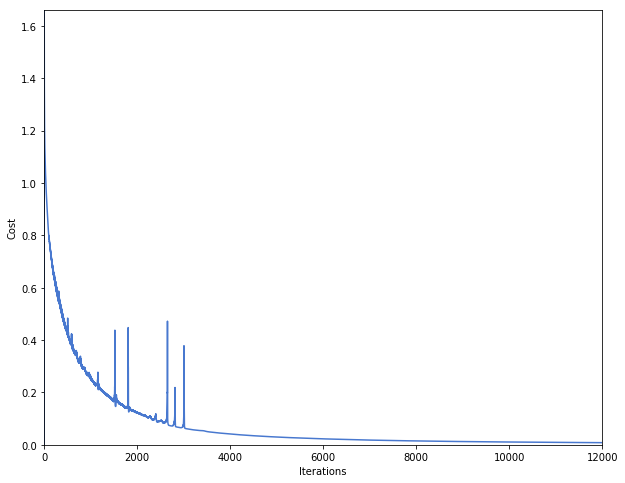

F-Score: 0.9655
finished


In [10]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

# training_epochs = 6000

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)

    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))

    saver.save(sess, "./checkpoints/"+"NN-model.ckpt")
    tf.train.write_graph(sess.graph_def, './tmp/model', 'ambient_nn.pb', as_text=False)

    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()

    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
    print("F-Score:", round(f,4))
    
print("finished")

In [12]:
l = [i for i in range(0,NUMBER_OF_CLASSES)]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred,labels=[i for i in range(0,NUMBER_OF_CLASSES)])
print(cm)


[[57  0  0  0]
 [ 1 70  1  0]
 [ 0  5 61  1]
 [ 0  0  1 32]]


In [13]:
# from prettytable import PrettyTable
count = [0.00 for i in range(0,NUMBER_OF_CLASSES)]
for i in y_true:
    count[i] += 1


copy = list()
for index1, l in enumerate(cm):
    copy.append([])
    for index2, item in enumerate(l):
        copy[index1].append(item / count[index1] * 100)



names = ["air_conditioner","children_playing","street_music", "talking"]
layout = "{!s:^10} {!s:^10} {!s:^10} {!s:^10} {!s:^10}"
print(layout.format("", names[0], names[1], names[2], names[3]))
list_layout = "{!s:<10} {:^10.4f} {:^10.4f} {:^10.4f} {:^10.4f}"
# nums = [12.0, 13.234234,12.2323232323,12.2323232323,12.2323232323,12.2323232323,99.123123123123,99.123123123123,99.123123123123,99.123123123123]
# print(list_layout.format("air_cond",*nums))
for i in range(len(copy)):
    to_print = [names[i]] + copy[i]
    print(list_layout.format(*to_print))

           air_conditioner children_playing street_music  talking  
air_conditioner  100.0000    0.0000     0.0000     0.0000  
children_playing   1.3889    97.2222     1.3889     0.0000  
street_music   0.0000     7.4627    91.0448     1.4925  
talking      0.0000     0.0000     3.0303    96.9697  


## Test model with new data

In [19]:
print("Starting Audio parsing")
parent_dir = 'TalkingData'
dirs = ["set2", "fold3"]
features, labels = parse_audio_files(parent_dir, dirs)

print("Done parsing audio")

Starting Audio parsing
0 set2
1 fold3
Done parsing audio


In [20]:
f = open('./pickles/features_pred.pckl', 'wb')
pickle.dump(features,f)
f.close()
fl = open('pickles/labels_pred.pckl', 'wb')
pickle.dump(labels,fl)
fl.close()

In [21]:
f = open("./pickles/features_pred.pckl", 'rb')
features = pickle.load(f)
f.close()


fl = open("./pickles/labels_pred.pckl", "rb")
labels = pickle.load(fl)
fl.close()

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./checkpoints/NN-model.ckpt")
    print("Model restored")
    new_pred = sess.run(tf.argmax(y_,1),feed_dict={X: features})
    saver.save(sess, "./checkpoints/"+"NN-model.ckpt")
print("finished")

INFO:tensorflow:Restoring parameters from ./checkpoints/NN-model.ckpt
Model restored
finished


In [23]:
data_types = {0: "air_conditioner", 1: "children_playing", 2: "street_music", 3: "talking"}

predSum = 0
timer = 0

counts = {
    "air_conditioner": 0,
    "children_playing": 0,
    "street_music": 0,
    "talking": 0
}

for i in new_pred:
    if (str(data_types[labels[timer]]) == str(names[i])):
        predSum += 1
    else:
        counts[names[i]] += 1
        
    timer += 1
print(new_pred.shape)
print(predSum / new_pred.shape[0])
print(counts)

0.4906832298136646
{'air_conditioner': 0, 'children_playing': 88, 'street_music': 49, 'talking': 27}
